In [ ]:

print("All necessary libraries are pre-installed in Google Colab.")

All necessary libraries are pre-installed in Google Colab.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

print("Please upload the 'it_monitoring_dummy_dataset.csv' file.")
uploaded = files.upload()

if len(uploaded.keys()) > 0:
    DATA_FILE_PATH = list(uploaded.keys())[0]
    print(f"\nSuccessfully uploaded '{DATA_FILE_PATH}'")
else:
    print("\nUpload failed or was cancelled.")

Please upload the 'it_monitoring_dummy_dataset.csv' file.


Saving it_monitoring_dummy_dataset.csv to it_monitoring_dummy_dataset.csv

Successfully uploaded 'it_monitoring_dummy_dataset.csv'


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import os


np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)


print("1. Loading and cleaning data...")
df = pd.read_csv(DATA_FILE_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%M:%S.%f', errors='coerce').dt.time
df = df.sort_values(['server_id', 'timestamp']).reset_index(drop=True)
df = df.dropna() # Drop rows with parsing errors

print("2. Simulating missing disk metrics for analysis...")
df['disk_io_read'] = df['network_in'] / 5 + np.random.normal(0, 5, size=len(df))
df['disk_io_write'] = df['network_out'] / 3 + np.random.normal(0, 5, size=len(df))
df['disk_utilization'] = 70 + 5 * np.sin(np.arange(len(df)) / 100) + np.random.uniform(-1, 1, len(df))
df['disk_utilization'] = df['disk_utilization'].clip(0, 100)
print("   - Original columns:", list(pd.read_csv(DATA_FILE_PATH).columns))
print("   - Columns after augmentation:", list(df.columns))


print("3. Scaling features and splitting data...")
features = ['cpu_usage', 'memory_usage', 'network_in', 'network_out', 'disk_io_read', 'disk_io_write', 'disk_utilization']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train = X_scaled


print("4. Training AI models...")

#Model 1: Isolation Forest
print("   - Training Isolation Forest...")
iso_forest = IsolationForest(contamination=0.02, random_state=42) # Expect 2% anomalies
iso_anomalies = iso_forest.fit_predict(X_train)

#Model 2: Autoencoder
print("   - Training Autoencoder...")
input_dim = X_train.shape[1]
encoding_dim = max(2, input_dim // 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, verbose=0)


X_pred = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - X_pred, 2), axis=1)
threshold = np.percentile(mse, 98) # Flag top 2% of errors as anomalies
ae_anomalies = np.where(mse > threshold, -1, 1)


print("5. Preparing results for visualization...")
results_df = df.copy()
results_df['iso_anomaly'] = iso_anomalies
results_df['ae_anomaly'] = ae_anomalies

OUTPUT_DIR = 'results'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

1. Loading and cleaning data...
2. Simulating missing disk metrics for analysis...
   - Original columns: ['timestamp', 'server_id', 'cpu_usage', 'memory_usage', 'network_in', 'network_out']
   - Columns after augmentation: ['timestamp', 'server_id', 'cpu_usage', 'memory_usage', 'network_in', 'network_out', 'disk_io_read', 'disk_io_write', 'disk_utilization']
3. Scaling features and splitting data...
4. Training AI models...
   - Training Isolation Forest...
   - Training Autoencoder...
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
5. Preparing results for visualization...


6. Generating and saving visualizations to 'results' directory...


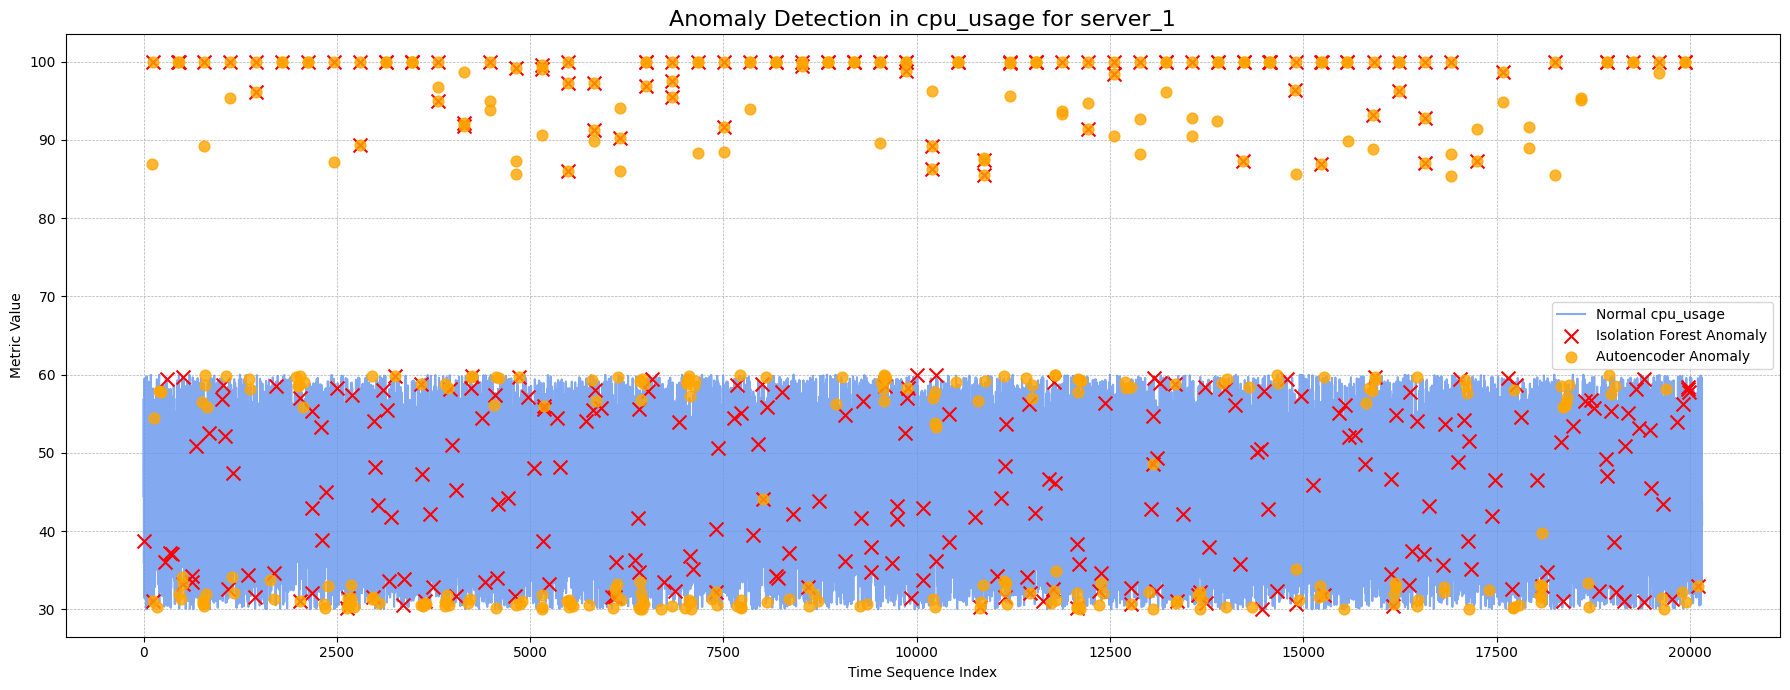

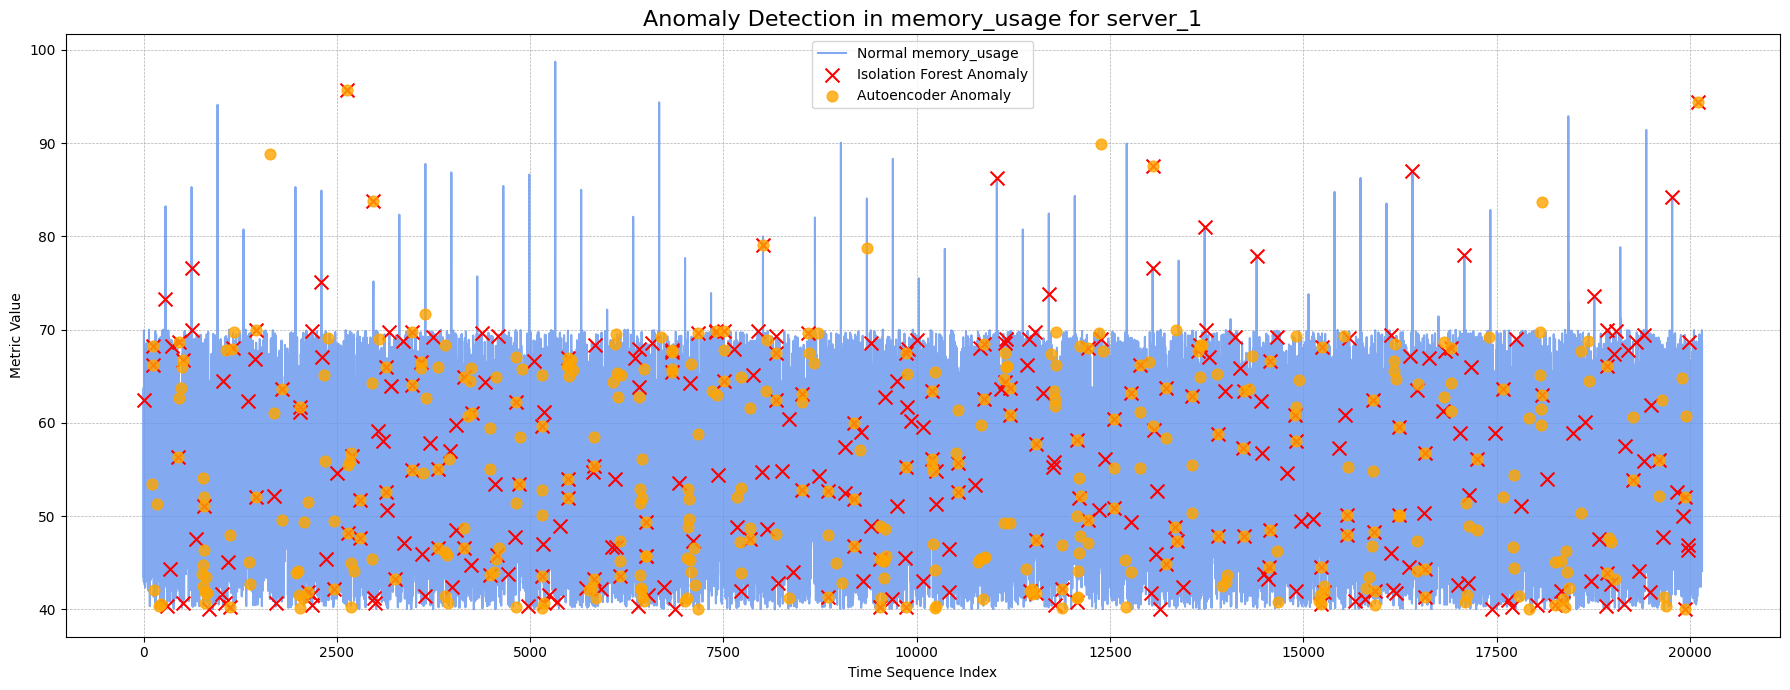

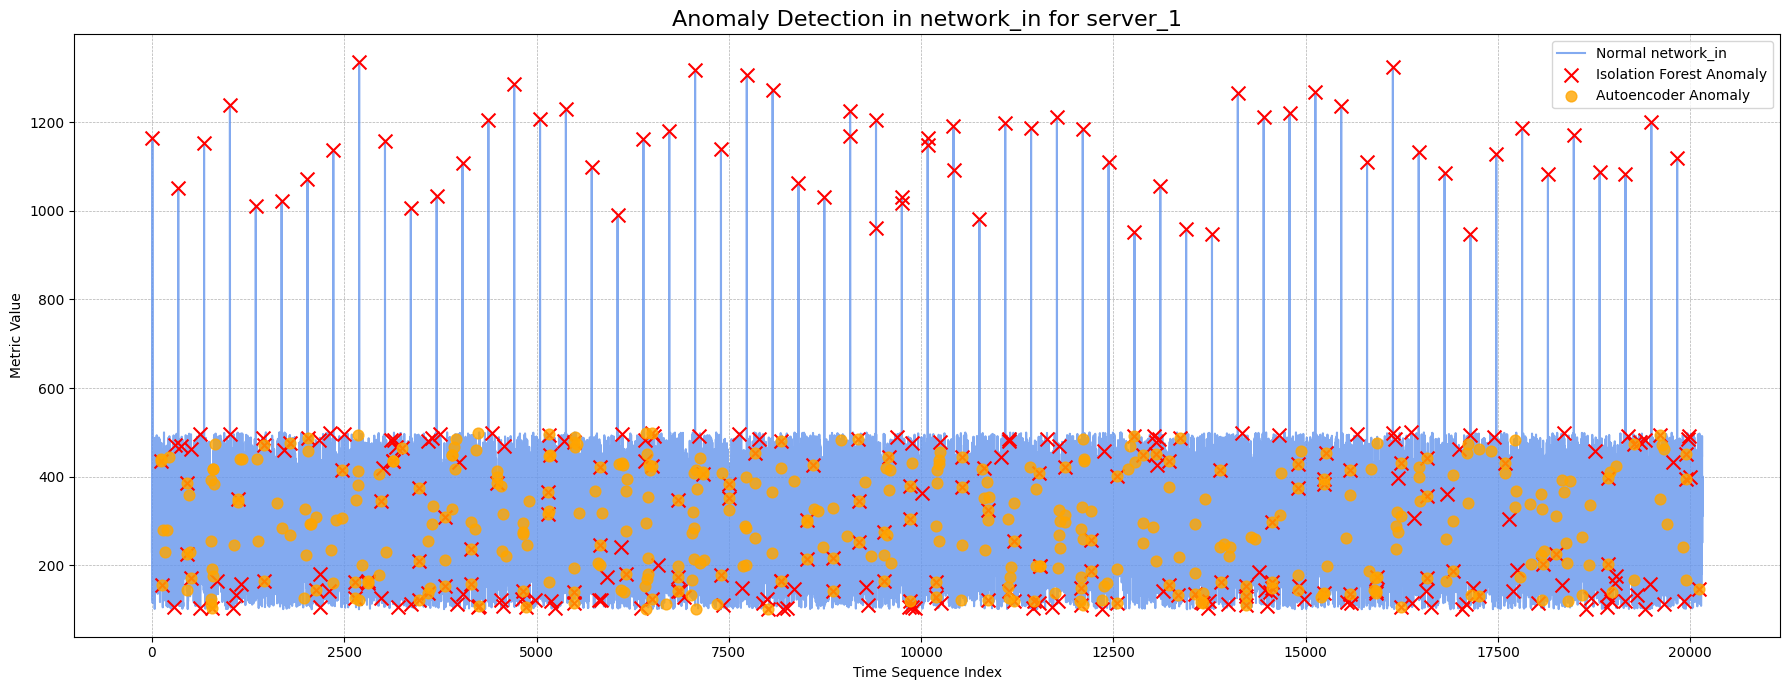

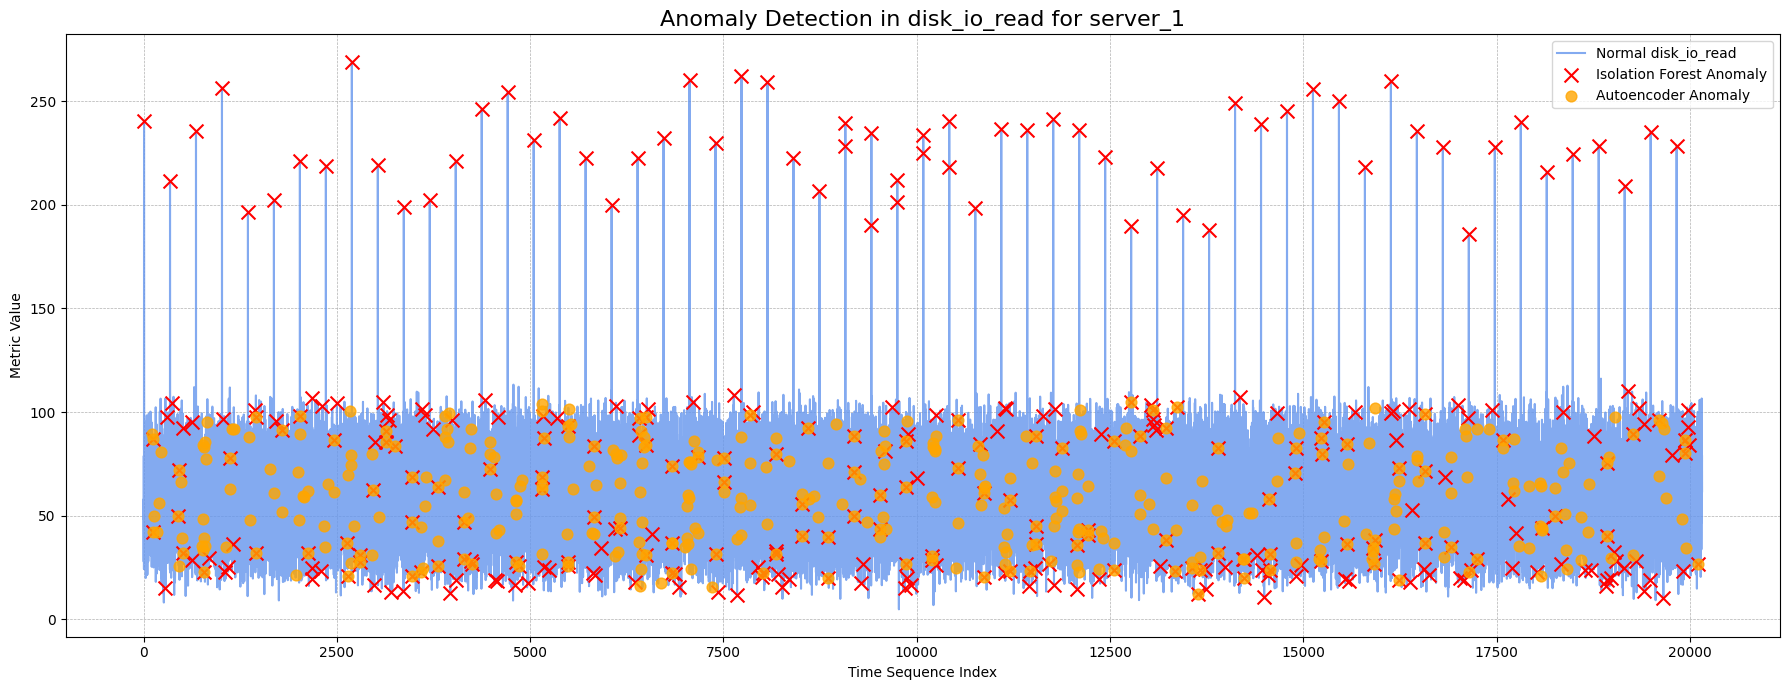

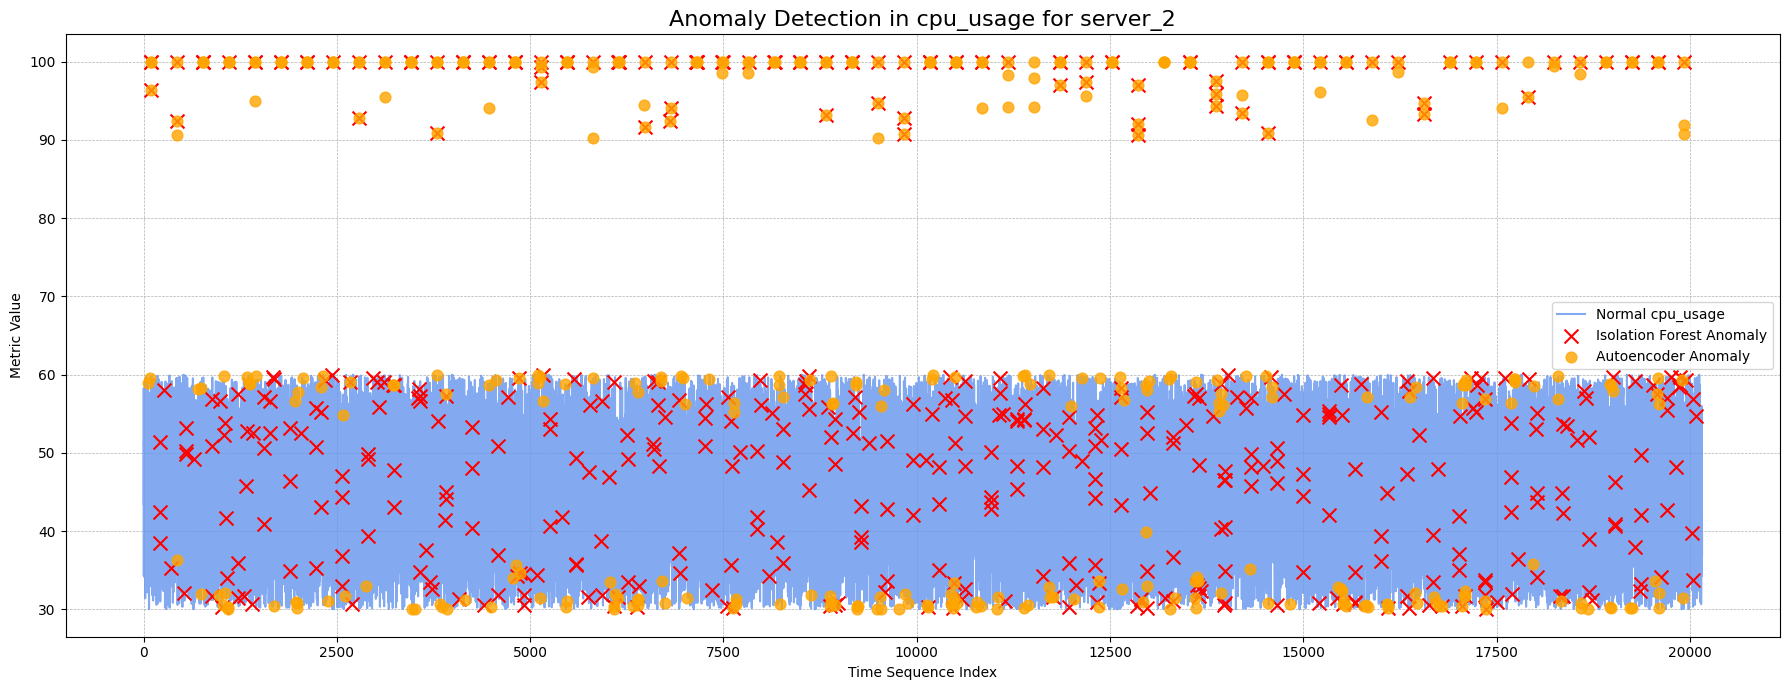

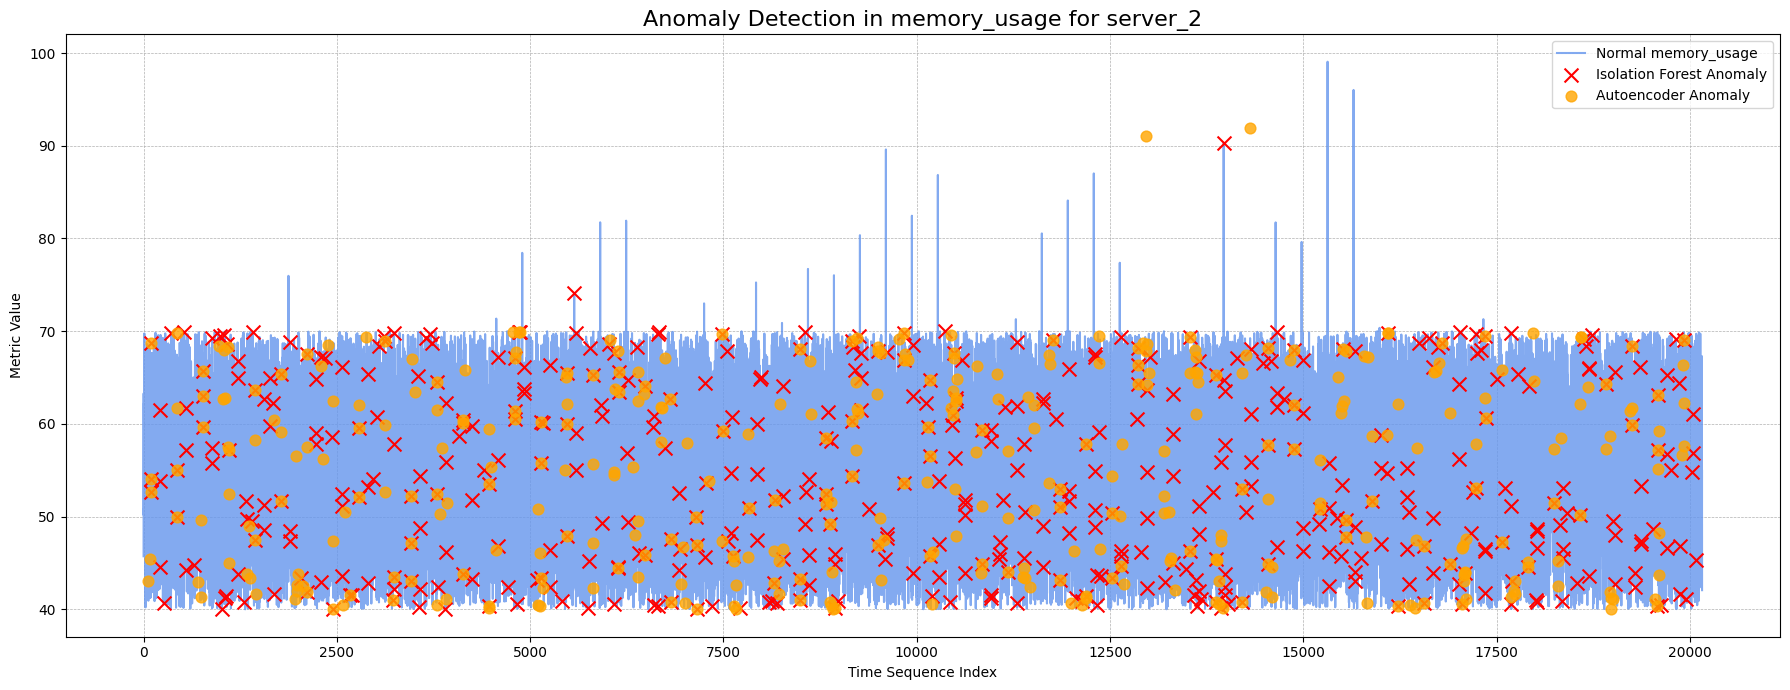

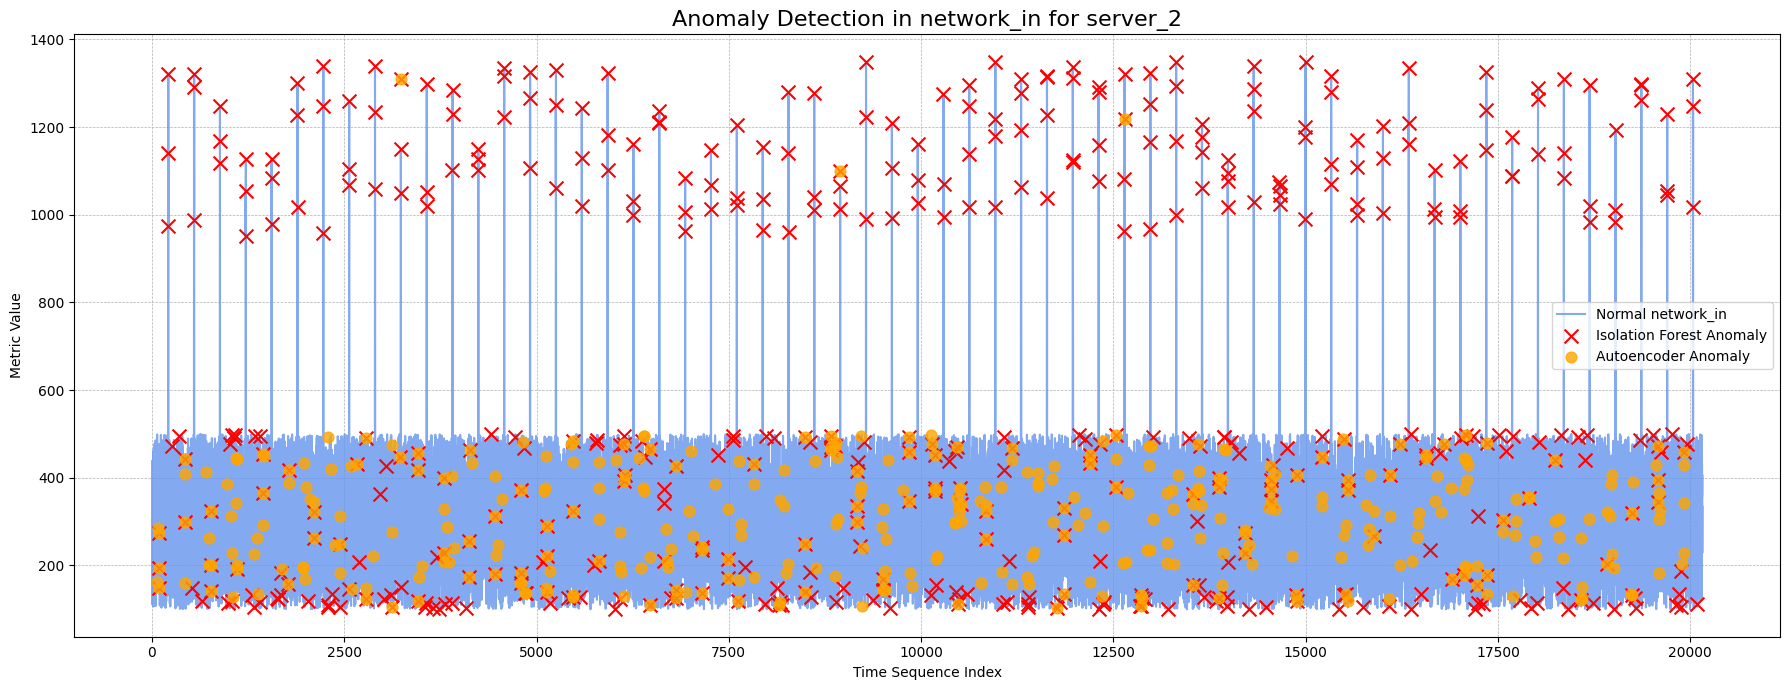

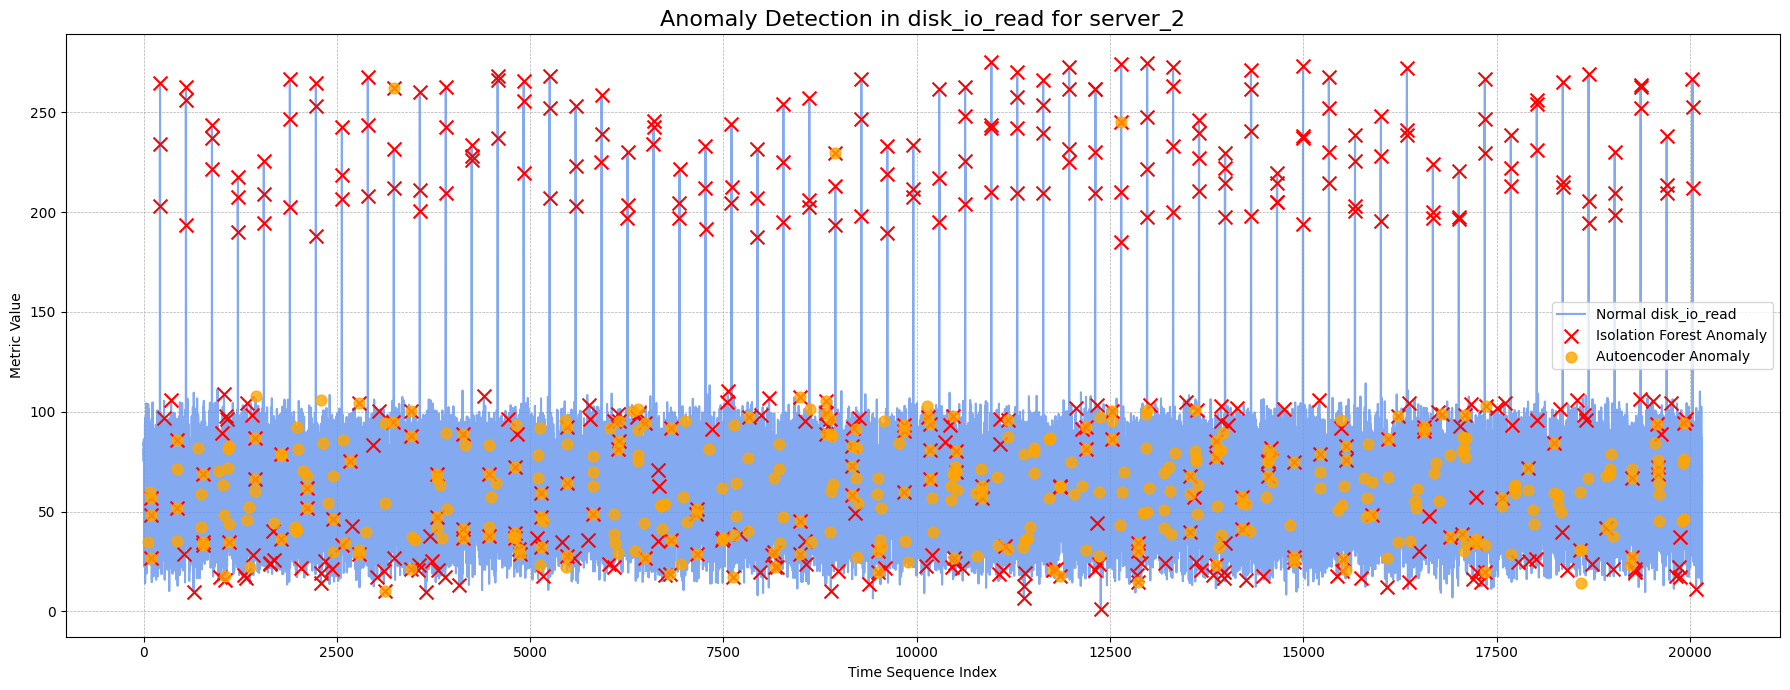

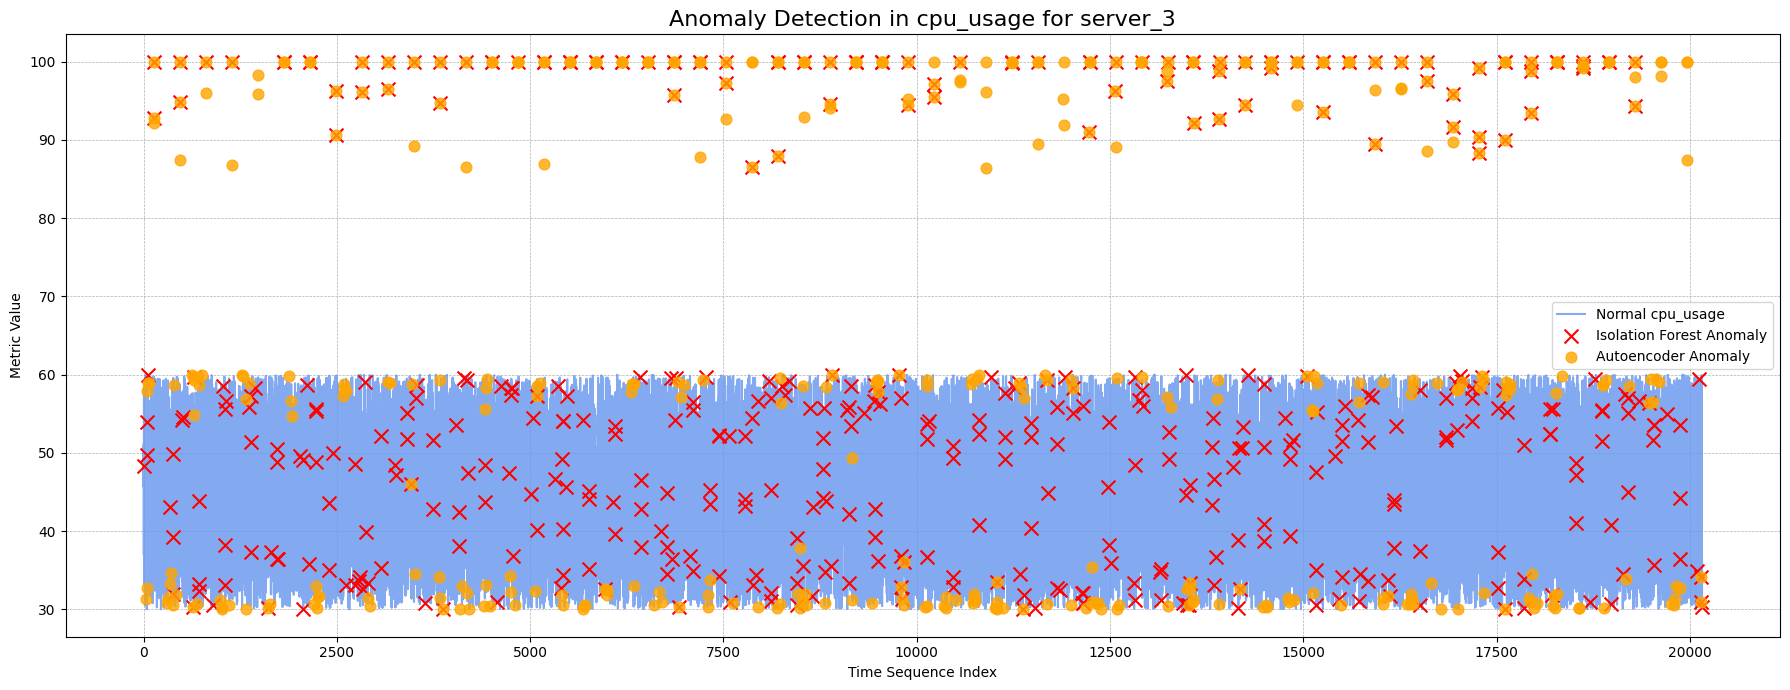

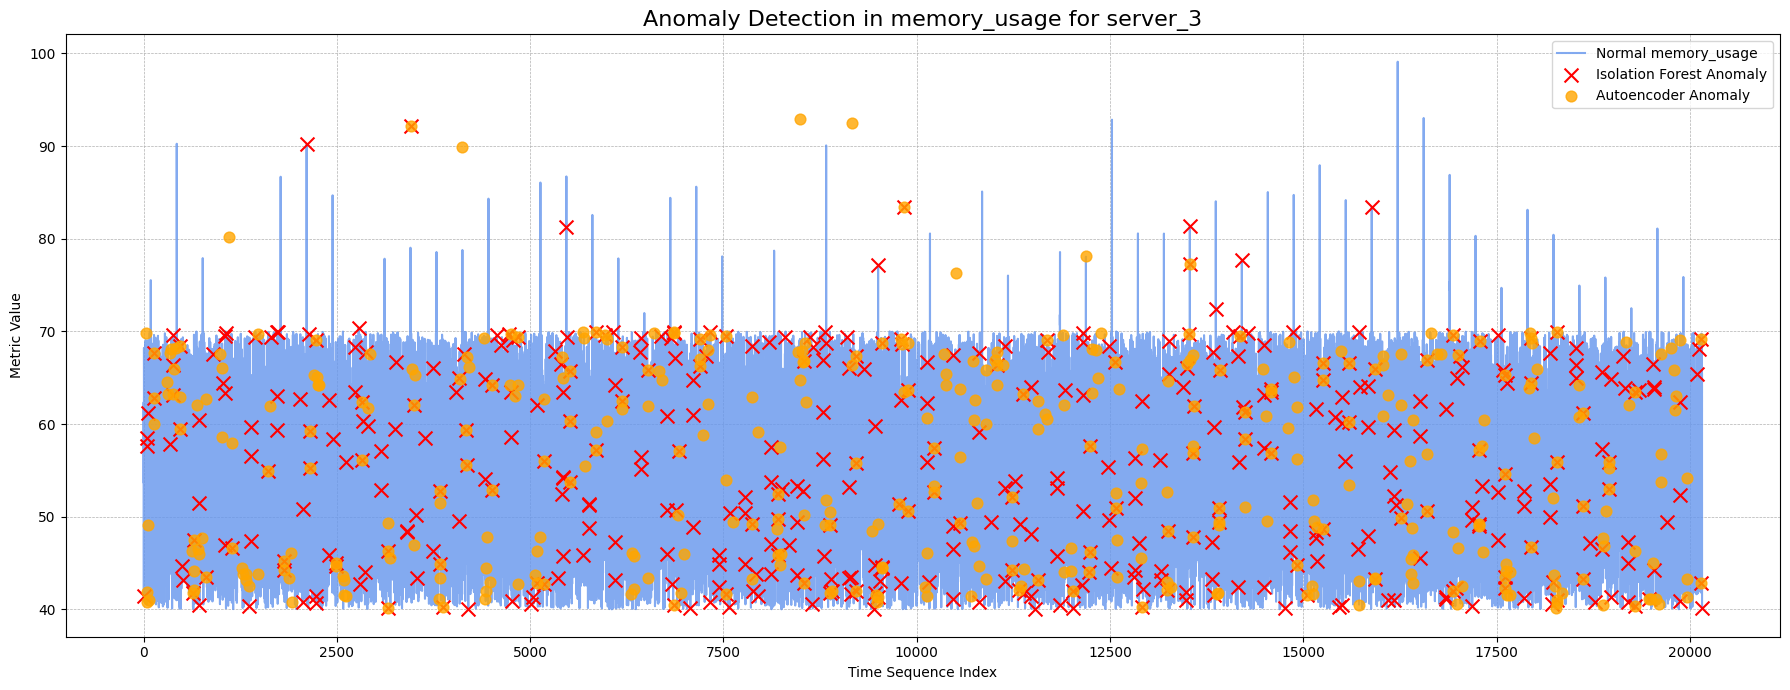

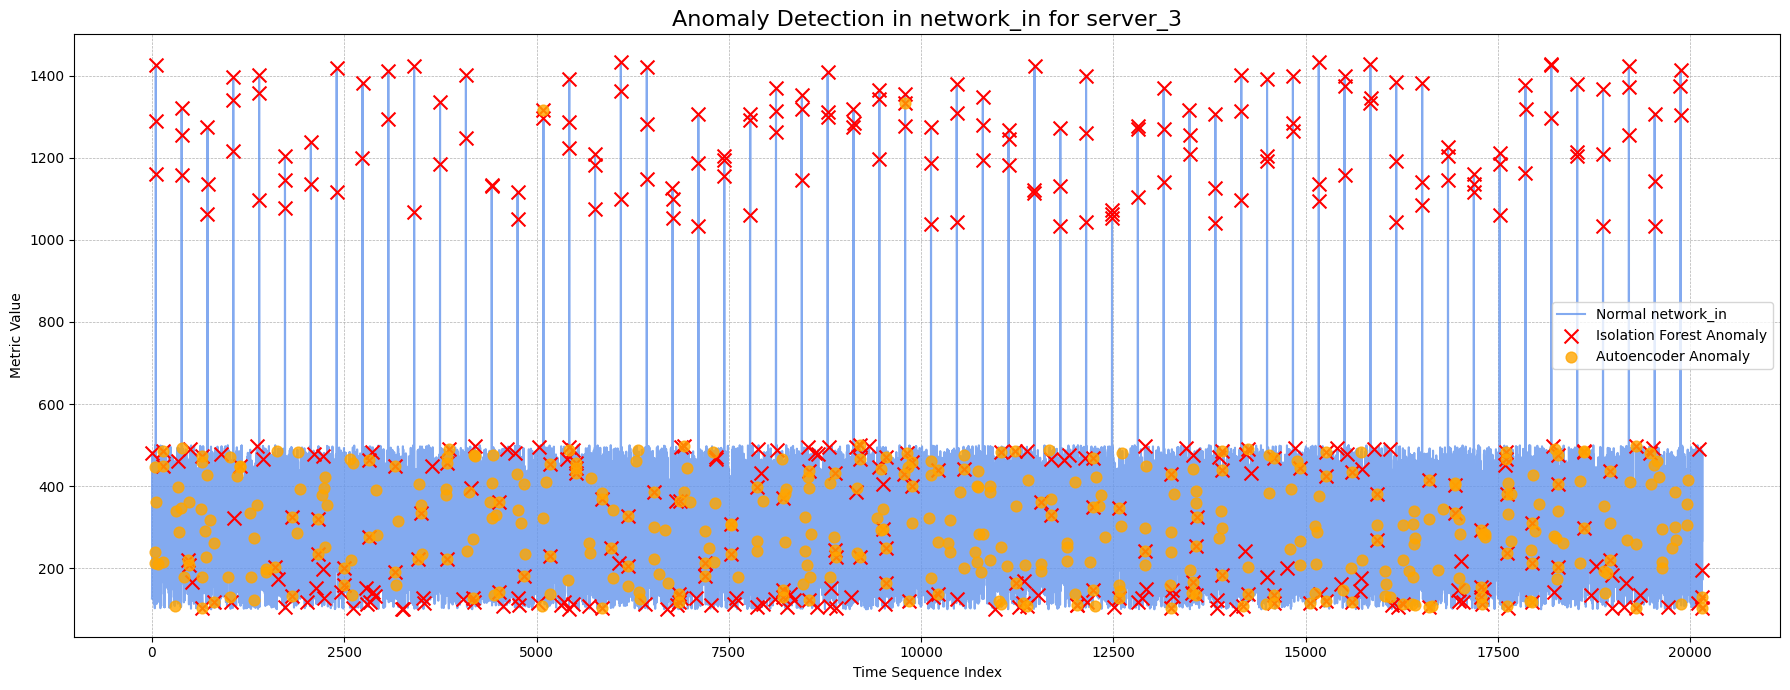

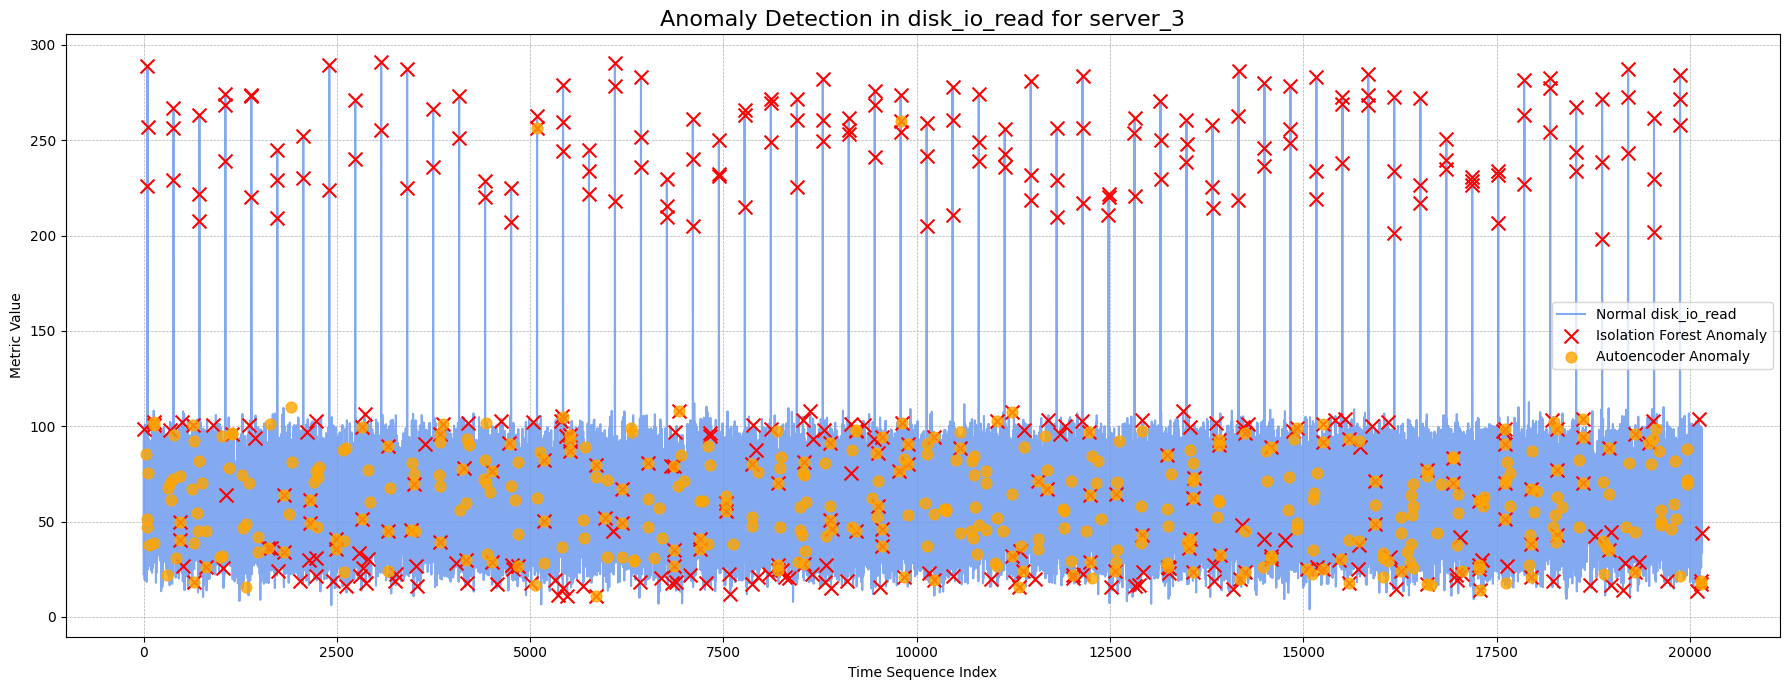

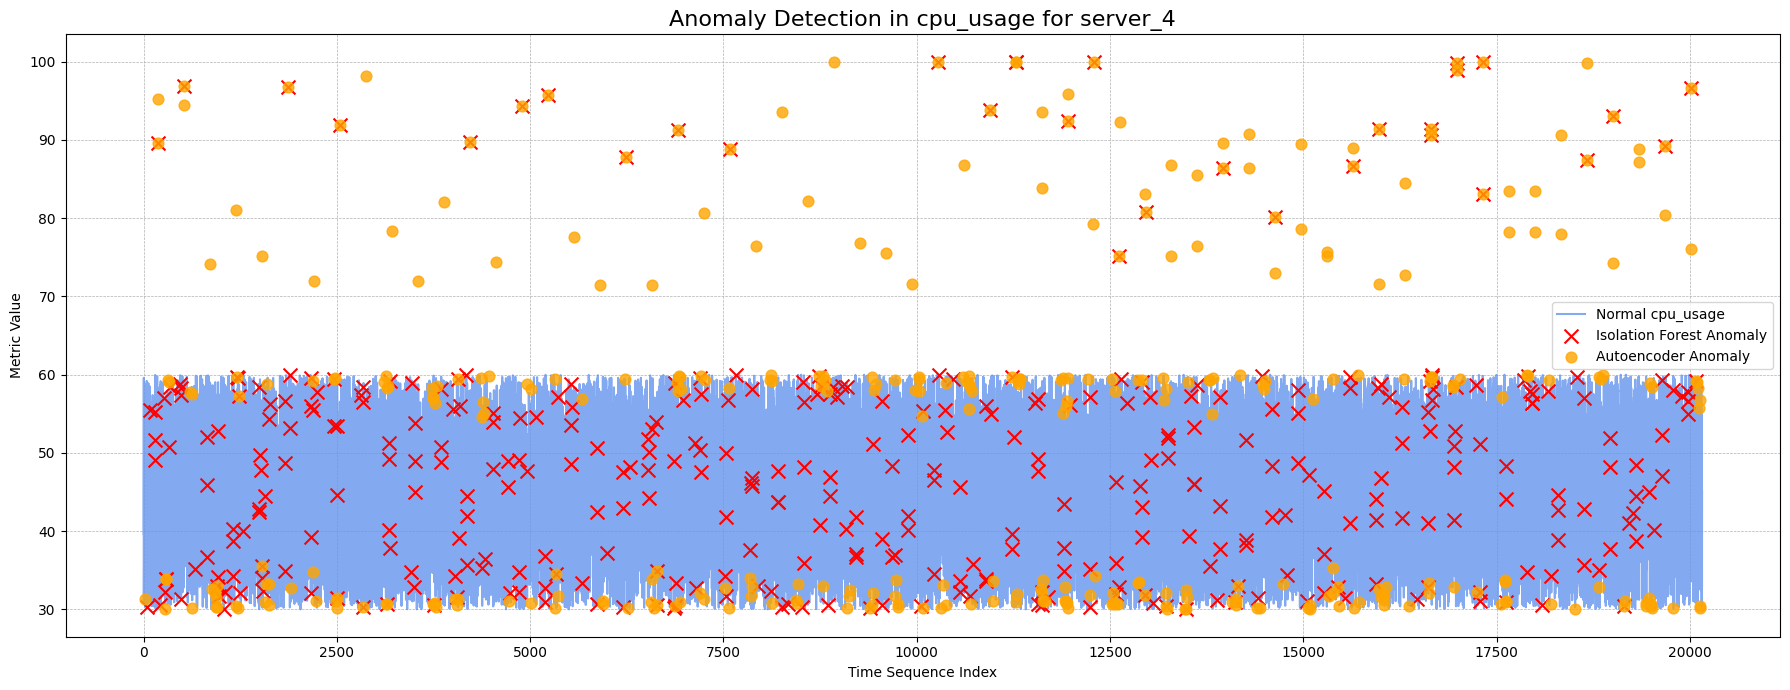

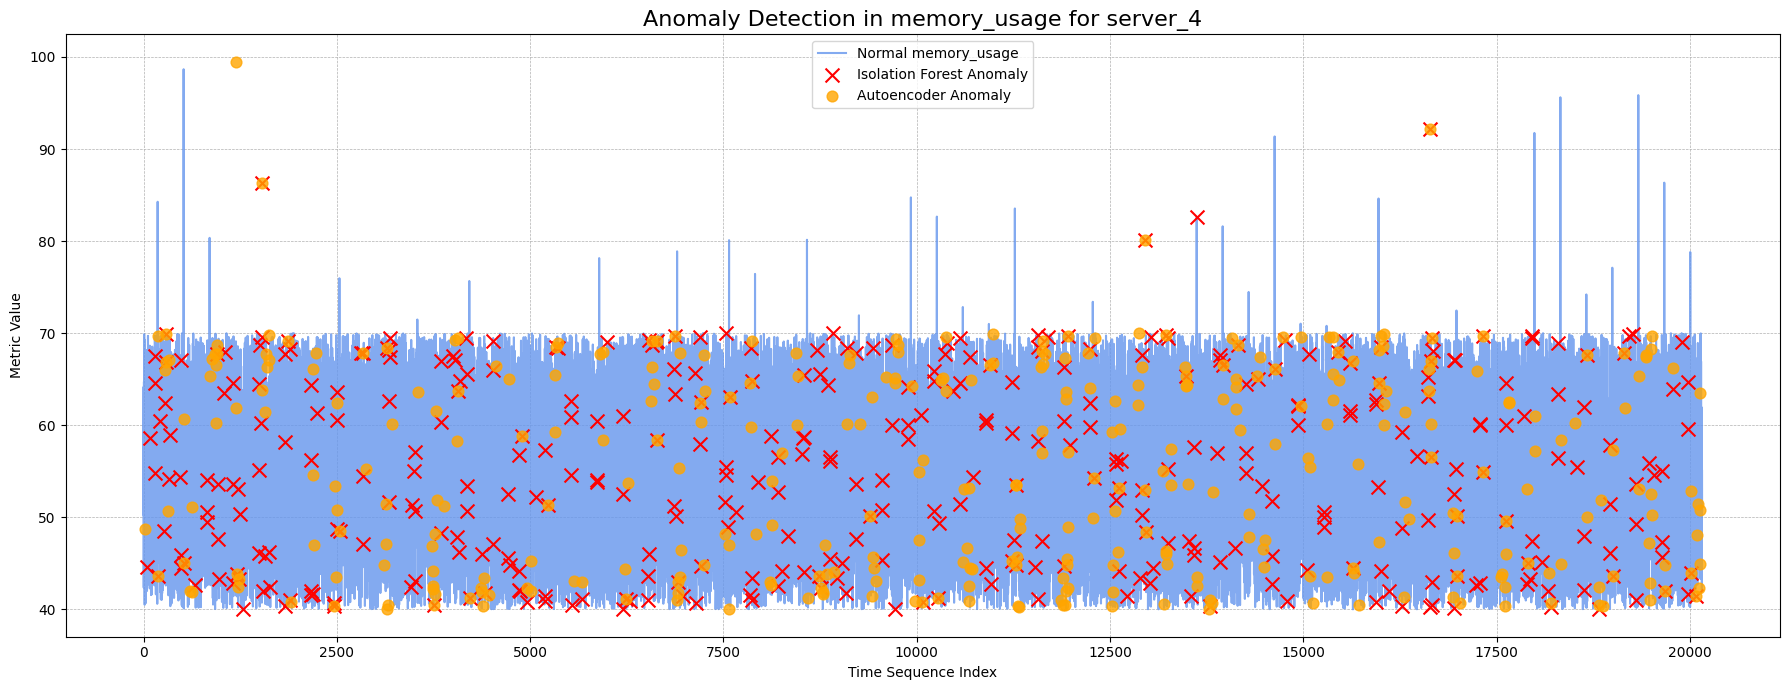

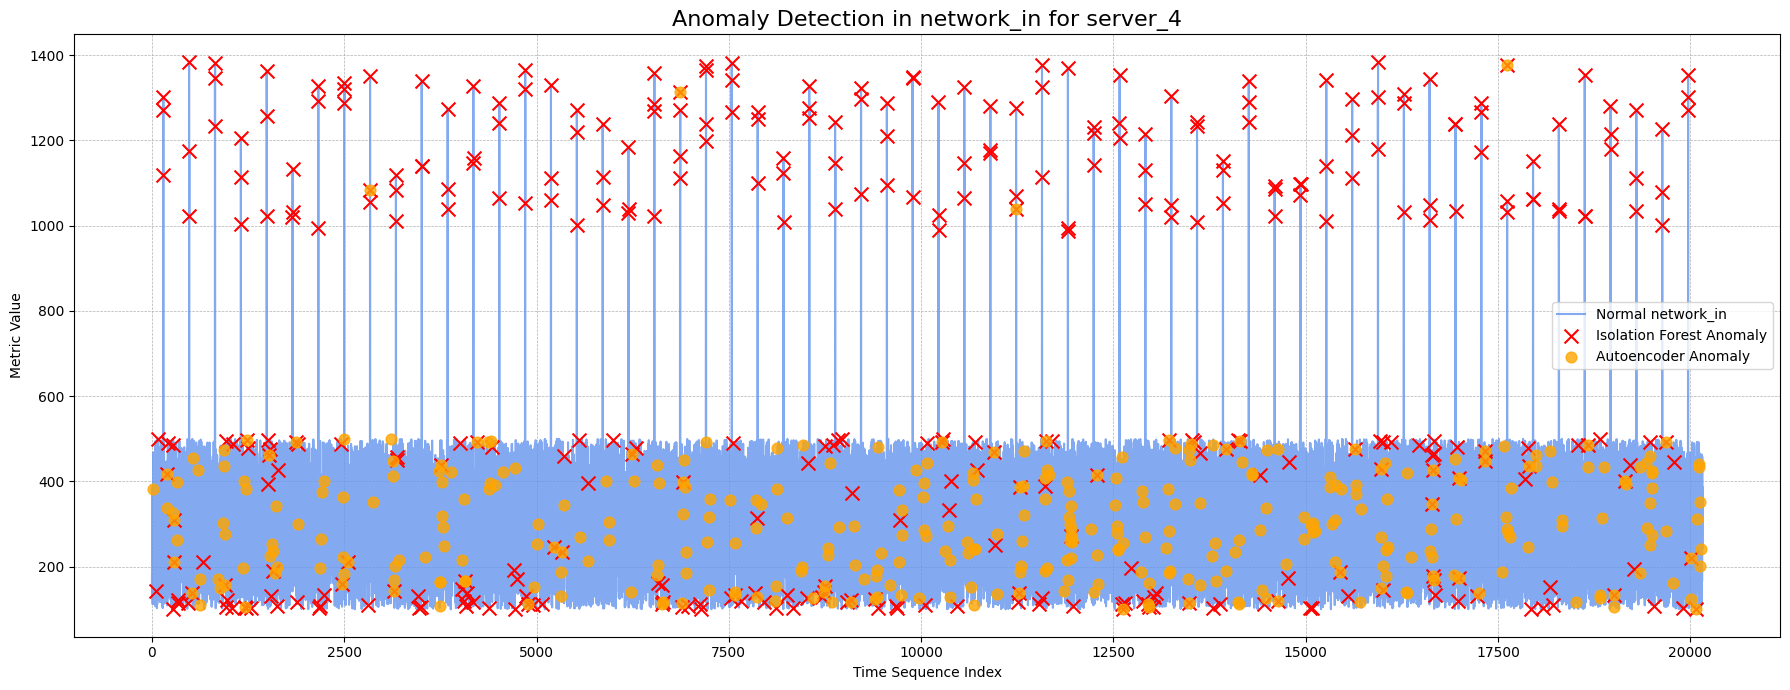

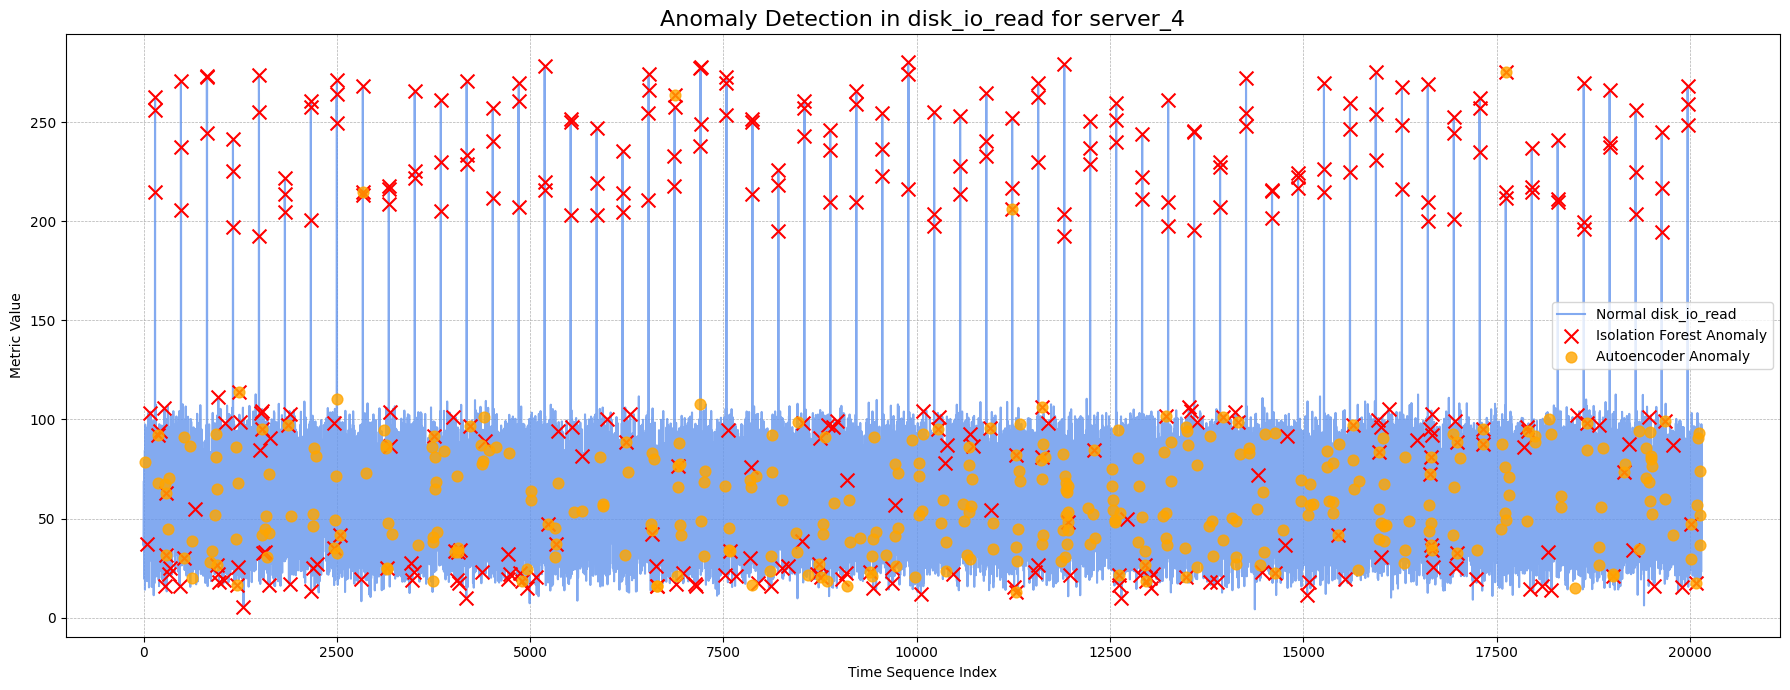

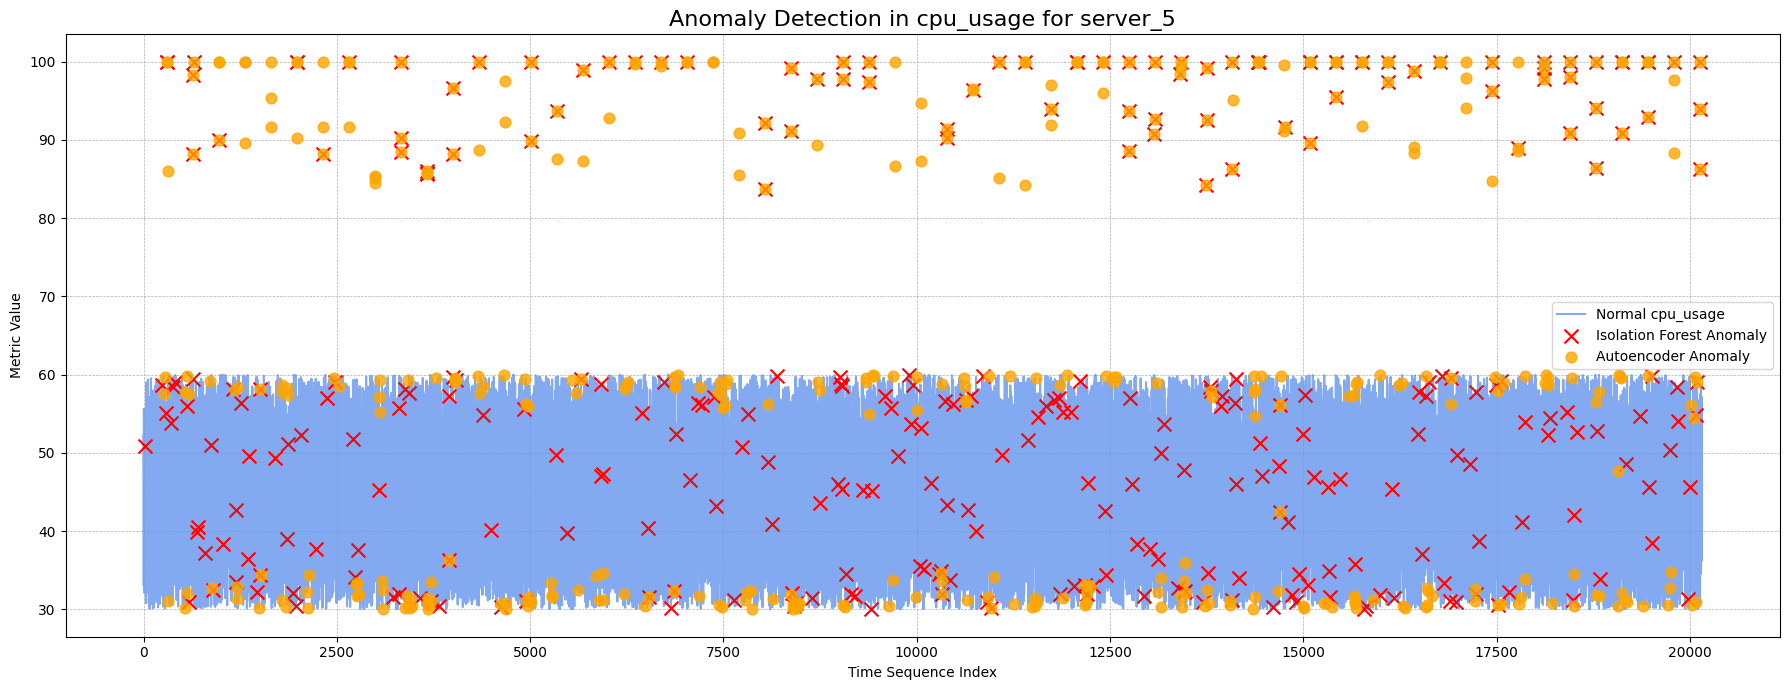

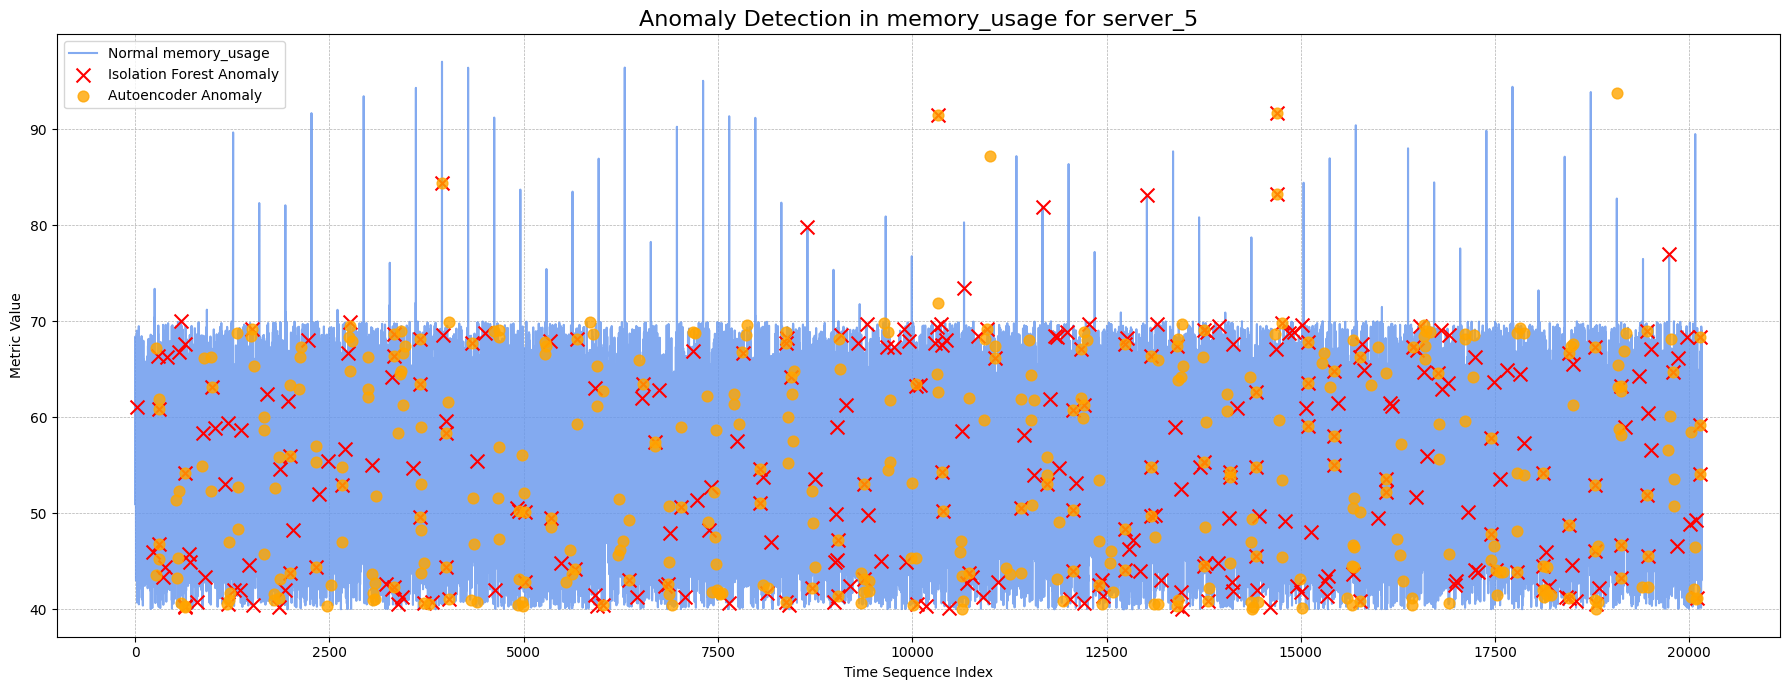

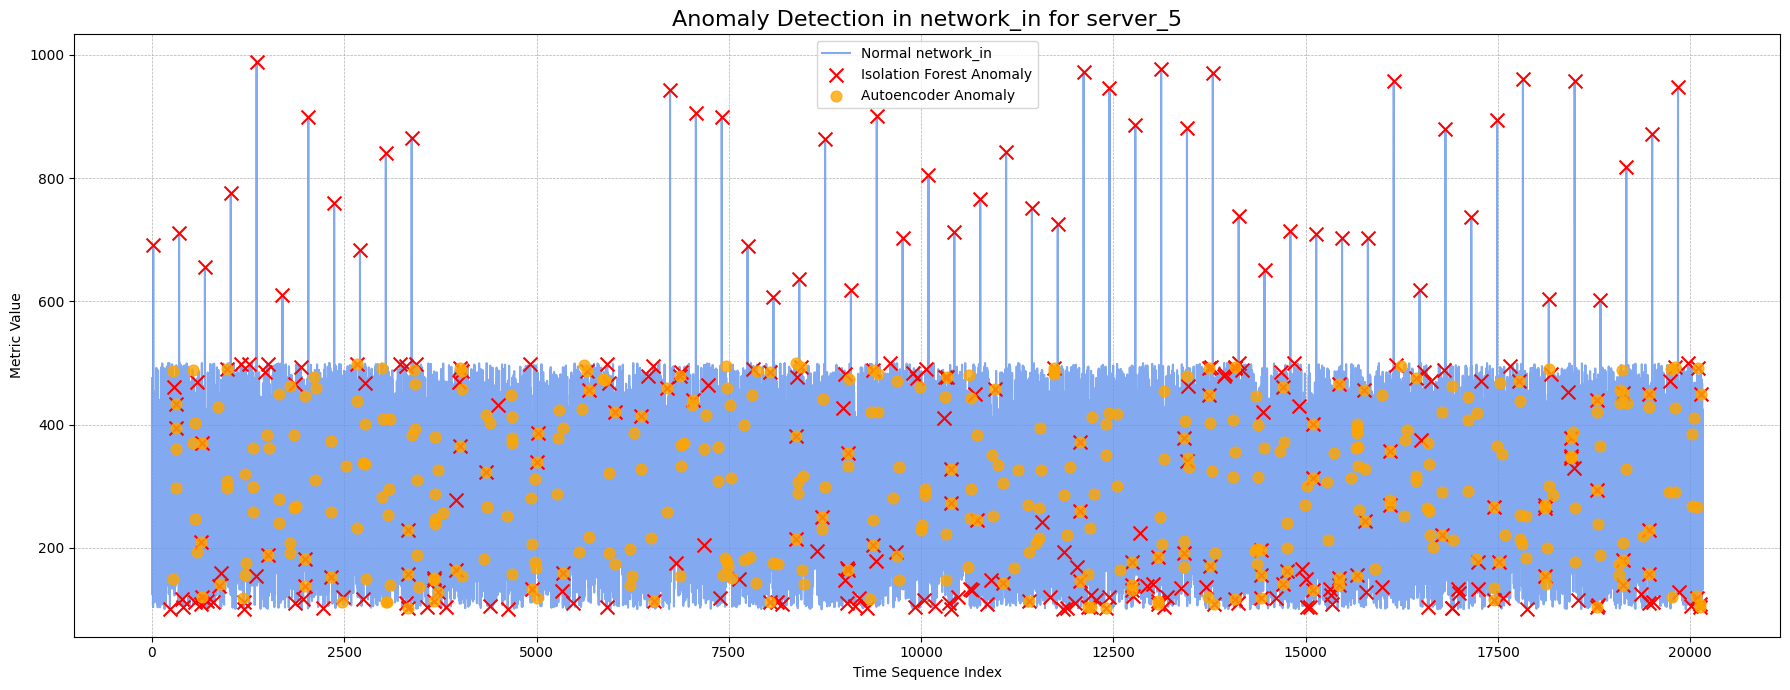

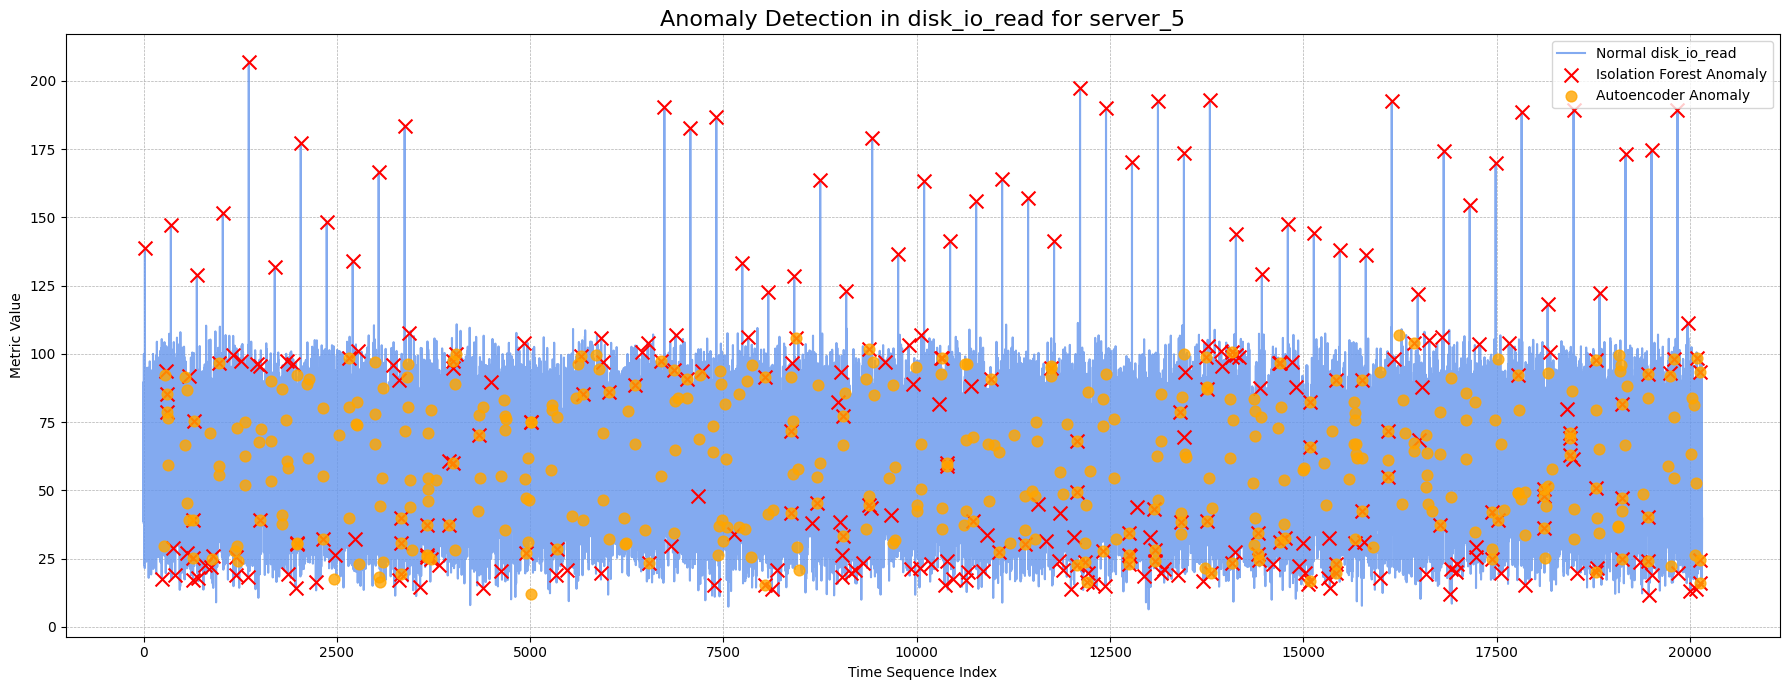


Visualization complete.


In [ ]:

print(f"6. Generating and saving visualizations to '{OUTPUT_DIR}' directory...")
metrics_to_plot = ['cpu_usage', 'memory_usage', 'network_in', 'disk_io_read']

for server in results_df['server_id'].unique():
    server_df = results_df[results_df['server_id'] == server].reset_index()
    for metric in metrics_to_plot:
        plt.figure(figsize=(18, 7))

        normal_points = server_df[server_df['ae_anomaly'] == 1]
        plt.plot(normal_points.index, normal_points[metric], label=f'Normal {metric}', color='cornflowerblue', alpha=0.8, linestyle='-')

        iso_anom_points = server_df[server_df['iso_anomaly'] == -1]
        ae_anom_points = server_df[server_df['ae_anomaly'] == -1]

        if not iso_anom_points.empty:
            plt.scatter(iso_anom_points.index, iso_anom_points[metric], color='red', marker='x', s=100, label='Isolation Forest Anomaly', zorder=5)
        if not ae_anom_points.empty:
            plt.scatter(ae_anom_points.index, ae_anom_points[metric], color='orange', marker='o', s=60, alpha=0.8, label='Autoencoder Anomaly', zorder=5)

        plt.title(f'Anomaly Detection in {metric} for {server}', fontsize=16)
        plt.xlabel('Time Sequence Index')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        plt.savefig(os.path.join(OUTPUT_DIR, f'{server}_{metric}_anomalies.png'))
        plt.show()

print("\nVisualization complete.")